In [1]:
#20202161008
#陈思韬
#2020级人工智能一班
#调整
#1.删除了OOV
#2.在载入词向量，def get_weight_matrix函数中，加入了判断
#if word in model: 语句确实可以帮助避免由于词表中包含了
#不在预训练词向量模型中的词而引发的 KeyError 错误

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import jieba
import gensim

# 1. 准备数据
def clearTxt(inTxt):
    t=inTxt.replace('[:|\d|\-|#|\n\t.]','')\
    .replace('删除',',').replace('，',',').replace('送餐',',').replace('两个',',').replace('第一次',',').replace('一份',',').replace('一个半',',').replace('一个多',',').replace('半小时',',').replace('菜量',',').replace('我要',',').replace('三个',',').replace('两份',',').replace('催单',',').replace('半个',',').replace('两次',',').replace('我点',',').replace('第二次',',').replace('这是',',').replace('几次',',').replace('不太',',').replace('超快',',').replace('十点',',').replace('一口',',').replace('还会',',')\
    .replace('量少',',').replace('一般般',',').replace('取餐',',').replace('没送',',').replace('太咸',',').replace('再点',',').replace('点餐',',').replace('点半',',').replace('京酱',',').replace('没熟',',')\
    .replace('一碗',',').replace('一盒',',').replace('点多',',').replace('一股',',').replace('外送',',').replace('好慢',',').replace('三次',',').replace('再订',',').replace('一杯',',').replace('一根',',').replace('一看',',').replace('十一点',',')\
    .replace('很赞',',').replace('多分钟',',').replace('超慢',',').replace('太坑',',').replace('送得',',').replace('给力',',').replace('补送',',')\
    .replace('微辣',',').replace('几个',',').replace('十分钟',',').replace('我定',',').replace('不订',',').replace('全撒',',').replace('面都',',')\
    .replace('一点点',',').replace('半盒',',').replace('两点',',').replace('很足',',').replace('几天',',').replace('不辣',',').replace('多点',',')\
    .replace('十二点',',').replace('还少',',').replace('点才',',').replace('量足',',').replace('太辣',',').replace('不接',',').replace('不送',',')\
    .replace('太淡',',').replace('一句',',').replace('几块',',').replace('一层',',').replace('半杯',',').replace('点赞',',').replace('超赞',',')\
    .replace('太甜',',').replace('黄太吉',',').replace('不像',',').replace('巨慢',',').replace('香锅',',').replace('几口',',').replace('中份',',')\
    .replace('送成',',').replace('不买',',').replace('饭里',',').replace('差差',',').replace('没带',',').replace('退单',',').replace('第二天',',')\
    .replace('餐到',',').replace('我订',',').replace('凉透',',')
    return t


def Txt2Seq(txt):
    #停词词典
    stoplist=set(line.strip() for line in open('stop_words.txt',encoding='UTF-8'))
    
    #分词
    words=jieba.lcut(clearTxt(txt))
    words=[w.lower().strip() for w in words if w.lower().strip() not in stoplist]
    return words


df=pd.read_csv('waimai_10k.csv')
texts=df['review'].map(Txt2Seq)#对df每一行都调用Txt2Seq,把停用词中的词语替换成,最后是二维列表

labels=df['label']
len(texts)

# 2. 数据分割
X_train,X_test,y_train,y_test=train_test_split(texts,labels,test_size=0.2,random_state=42)
max_words=1000
tokenizer=Tokenizer(num_words=max_words,oov_token='OOO') #词进行编码
tokenizer.fit_on_texts(texts)

X_train_sequences=tokenizer.texts_to_sequences(X_train)#文本转成数字特征
X_test_sequences=tokenizer.texts_to_sequences(X_test)
X_train_sequences[:5]

max_sequence_length = 50  # 假设每个句子最大长度为100
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
X_train_padded[:5]

EMBEDDING_DIM = 300  # 假设词向量维度为300

# 4. 加载预训练的词向量模型
K2V = gensim.models.KeyedVectors.load('sgns.merge.word.kv')

def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    print(weight_matrix)
    for word, i in vocab.items():
        if word in model:
            weight_matrix[i] = model[word]
    return weight_matrix
#或者是把return缩进到后面也可以解决key的问题

#调用函数得到权重矩阵
vocab_size=len(tokenizer.word_index)+1
print(vocab_size)
word_index=tokenizer.word_index
embedding_vectors=get_weight_matrix(K2V,word_index)


# 5. 构建情感分析模型
MAX_LEN=50
model=keras.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, embeddings_initializer=keras.initializers.Constant(embedding_vectors), input_length=MAX_LEN),  # 注意这里加逗号
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


# 6. 编译模型t
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 7. 模型训练
epochs = 10
model.fit(X_train_padded, y_train, epochs=epochs, validation_data=(X_test_padded, y_test))

# 8. 模型评估
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print('Test accuracy:', test_accuracy)
print('Test loss:', test_loss)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\11865\AppData\Local\Temp\jieba.cache
Loading model cost 0.784 seconds.
Prefix dict has been built successfully.


10022
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Epoch 1/10
300/300 [==============================] - 28s 90ms/step - loss: 0.4598 - accuracy: 0.7854 - val_loss: 0.3645 - val_accuracy: 0.8474
Epoch 2/10
300/300 [==============================] - 27s 91ms/step - loss: 0.3132 - accuracy: 0.8678 - val_loss: 0.3572 - val_accuracy: 0.8486
Epoch 3/10
300/300 [==============================] - 27s 90ms/step - loss: 0.2519 - accuracy: 0.8961 - val_loss: 0.4030 - val_accuracy: 0.8445
Epoch 4/10
300/300 [==============================] - 26s 88ms/step - loss: 0.1972 - accuracy: 0.9194 - val_loss: 0.4550 - val_accuracy: 0.8336
Epoch 5/10
300/300 [==============================] - 24s 82ms/step - loss: 0.1533 - accuracy: 0.9386 - val_loss: 0.4924 - val_accuracy: 0.8274
Epoch 6/10
300/300 [==============================] - 24s 82ms/step - loss: 0.1232 - accuracy: 0.9504 - val_loss: 0.54

In [13]:
# 9. 预测外卖评价情感（根据需要执行）
# 请在需要进行情感预测时，使用模型进行预测，并计算F1分数等性能指标。
from sklearn.metrics import f1_score, classification_report


# 预测测试集的情感标签
y_pred = model.predict(X_test_padded)

# 将模型输出的概率转换为二进制标签（0或1）
y_pred_binary = (y_pred > 0.5).astype(int)

# 计算F1分数
f1 = f1_score(y_test, y_pred_binary)

# 打印F1分数
print('F1分数:', f1)

classification_rep = classification_report(y_test, y_pred_binary)
print('分类报告:\n', classification_rep)


75/75 [==============================] - 0s 3ms/step
F1分数: 0.702557200538358
分类报告:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1594
           1       0.77      0.65      0.70       804

    accuracy                           0.82      2398
   macro avg       0.80      0.77      0.78      2398
weighted avg       0.81      0.82      0.81      2398



Epoch 1/10
300/300 [==============================] - 28s 92ms/step - loss: 0.0268 - accuracy: 0.9893 - val_loss: 1.2415 - val_accuracy: 0.8065
Epoch 2/10
300/300 [==============================] - 27s 91ms/step - loss: 0.0463 - accuracy: 0.9831 - val_loss: 1.2752 - val_accuracy: 0.8036
Epoch 3/10
300/300 [==============================] - 26s 88ms/step - loss: 0.0379 - accuracy: 0.9862 - val_loss: 1.1894 - val_accuracy: 0.8128
Epoch 4/10
300/300 [==============================] - 26s 88ms/step - loss: 0.0275 - accuracy: 0.9884 - val_loss: 1.2481 - val_accuracy: 0.8057
Epoch 5/10
300/300 [==============================] - 25s 85ms/step - loss: 0.0250 - accuracy: 0.9889 - val_loss: 1.2571 - val_accuracy: 0.8065
Epoch 6/10
300/300 [==============================] - 25s 85ms/step - loss: 0.0239 - accuracy: 0.9901 - val_loss: 1.2802 - val_accuracy: 0.8073
Epoch 7/10
300/300 [==============================] - 26s 87ms/step - loss: 0.0229 - accuracy: 0.9900 - val_loss: 1.3088 - val_accuracy:

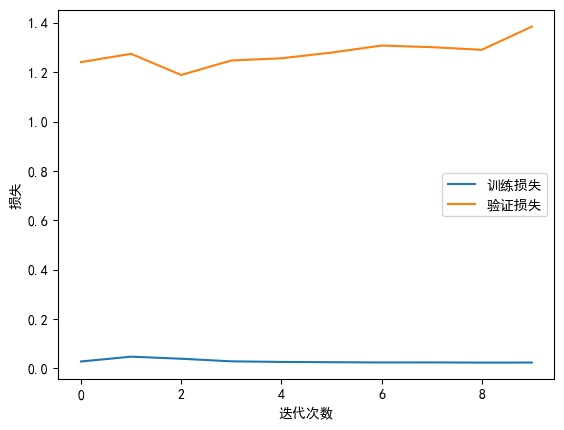

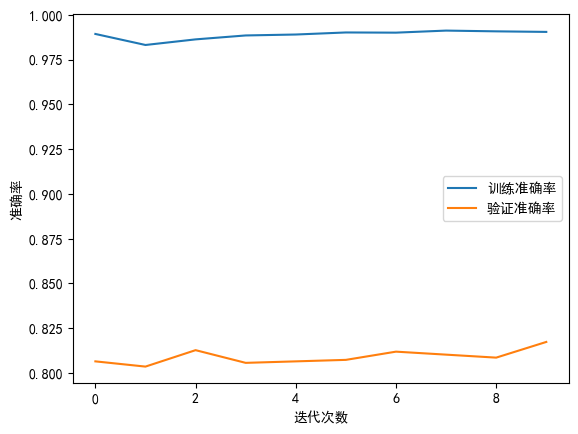

75/75 [==============================] - 0s 3ms/step


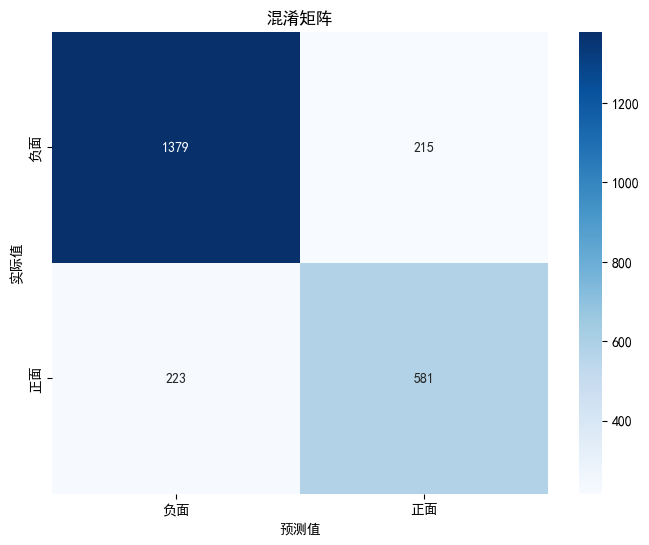

In [3]:
#可视化
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'SimHei'  # 使用中文字体，此处示例为宋体


# 训练模型
history = model.fit(X_train_padded, y_train, epochs=epochs, validation_data=(X_test_padded, y_test))

# 绘制训练集和验证集的损失值
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.xlabel('迭代次数')
plt.ylabel('损失')
plt.legend()
plt.show()

# 绘制训练集和验证集的准确率
plt.plot(history.history['accuracy'], label='训练准确率')
plt.plot(history.history['val_accuracy'], label='验证准确率')
plt.xlabel('迭代次数')
plt.ylabel('准确率')
plt.legend()
plt.show()

import seaborn as sns
from sklearn.metrics import confusion_matrix

# 预测测试集的情感标签
y_pred = model.predict(X_test_padded)
y_pred_binary = (y_pred > 0.5).astype(int)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred_binary)

# 创建热力图可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['负面', '正面'], yticklabels=['负面', '正面'])
plt.xlabel('预测值')
plt.ylabel('实际值')
plt.title('混淆矩阵')
plt.show()
